In [70]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
from datetime import datetime

from scipy.optimize import minimize, rosen, rosen_der

## Group Assignment
### Team Number: 06
### Team Member Names: Shayan Jalali, Krish Suryavanshi, Paul Reddy
### Team Strategy Chosen: Market Meet

## Ticker Filtering

The code below contains the logic used to clean and filter the raw tickers before building the portfolio. 

* We begin by importing a list of tickers from a CSV file. We first check whether each ticker has any historical data available in the specified date range. Only tickers with non-empty price data are retained.

* Next, we check if they are liquid. Illiquid stocks produce unreliable return estimates and unrealistic trading behavior, so we check for a minimum average daily trading volume of 5,000 shares. A month with fewer than 18 trading days is not considered representative and is excluded from the calculation.

* Once the valid months are identified, we calculate the stock’s average daily volume using only the trading days from these months. If the resulting average volume is at least 5,000 shares, the ticker is accepted; otherwise, it is removed.

In [71]:
csv_file = "Tickers_Example.csv" # given csv
tickers = pd.read_csv(csv_file, header=None, names=["Ticker"]) # read into a df

# include only valid US and Canadian companies with data between Oct 1, 2024 and Sep 30, 2025

start_date_filter = "2024-10-01"
end_date_filter = "2025-10-01" # to include sept 30th

valid_tickers = [] # empty list for tickers with data in the date range

for ticker in tickers["Ticker"]: # for each ticker
    hist = yf.Ticker(ticker).history(start=start_date_filter, end=end_date_filter) # get history
    
    if not hist.empty: # if history is not empty, we take it
        valid_tickers.append(ticker)

# exclude any stock with average daily volume < 5,000 shares between Oct 1, 2024 and Sep 30, 2025 (drop months with < 18 trading days)

volume_cutoff = 5000 # shares
minimum_trading_days = 18 # days
final_tickers = [] # empty list for final tickers after filtering with volume

for valid_ticker in valid_tickers: # for each valid ticker

    hist = yf.Ticker(valid_ticker).history(start=start_date_filter, end=end_date_filter) # get history
    months = list(hist.index.strftime("%Y-%m")) # turn daily dates into months

    unique_months = [] # to get rid of repeats
    for month in months:
        if month not in unique_months:
            unique_months.append(month)
    
    good_months = [] # to store months with enough trading days
    for unique_month in unique_months:
        if months.count(unique_month) >= minimum_trading_days:
            good_months.append(unique_month)
    
    mask = hist.index.strftime("%Y-%m").isin(good_months) # create mask for good months
    filtered_hist = hist[mask] # apply it to history

    # get the average daily volume using these months and decide if we keep the ticker
    avg_volume = filtered_hist["Volume"].mean()
    if avg_volume >= volume_cutoff:
        final_tickers.append(valid_ticker)

print()
print("Tickers after filtering:", final_tickers)
print("Filtered for", len(final_tickers), "from the given", len(tickers), "tickers.")

$CELG: possibly delisted; no timezone found
$MON: possibly delisted; no timezone found
$RTN: possibly delisted; no timezone found



Tickers after filtering: ['AAPL', 'ABBV', 'ABT', 'ACN', 'AGN.CN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BB.TO', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']
Filtered for 38 from the given 41 tickers.


## Selected Date Range for Analysis

Now we construct a DataFrame of daily closing prices for all tickers that passed both screens.

The date range we've opted to use for our analysis is ... because...

In [72]:
start_date_analysis = "2021-01-01"
end_date_analysis = "2025-11-21" # to include ...

close_prices = pd.DataFrame() # empty df
for final_ticker in final_tickers: # for each final ticker
    hist = yf.Ticker(final_ticker).history(start=start_date_analysis, end=end_date_analysis) # get history
    close_prices[final_ticker] = hist["Close"] # add the close prices to the df

close_prices.index = close_prices.index.strftime("%Y-%m-%d") # strip time from index

close_prices # display

,AAPL,ABBV,ABT,ACN,AGN.CN,AIG,AMZN,AXP,BA,BAC,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,125.974480,86.739716,99.687325,238.710403,5.445945,33.302513,159.331497,110.968620,202.720001,26.751955,...,134.018951,86.752411,139.619003,19.415180,57.709103,140.734833,324.313232,182.577164,133.249329,37.584763
2021-01-05,127.531998,87.636627,100.920715,240.069321,5.445945,33.858612,160.925507,111.560890,211.630005,26.956852,...,137.565659,87.307671,141.255997,19.621239,58.005894,141.767212,319.951965,184.816559,131.394577,37.707005
2021-01-06,123.239059,86.879601,100.710594,242.694199,5.445945,36.065018,156.919006,115.687881,211.029999,28.640539,...,136.446609,88.575623,137.604996,20.071514,59.650398,142.469940,333.379150,188.683792,131.004105,39.939922
2021-01-07,127.444366,87.809441,101.688164,244.983917,5.131756,36.674927,158.108002,114.772789,212.710007,29.273037,...,140.516800,89.561844,147.089996,20.079145,60.047668,145.697250,338.724060,191.309860,129.344589,40.738556
2021-01-08,128.544357,88.270248,101.971405,245.877502,5.236486,36.432755,159.134995,114.886017,209.899994,28.979059,...,141.365158,89.487259,151.671997,20.262306,60.088215,148.490784,337.202301,196.795914,128.848358,40.192554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,272.410004,232.360001,130.589996,245.210007,0.085000,77.750000,234.690002,357.179993,194.520004,52.610001,...,173.979996,205.460007,204.919998,20.379999,114.050003,159.330002,321.859985,223.020004,94.340004,47.099998
2025-11-17,267.459991,234.000000,130.029999,241.330002,0.085000,76.459999,232.869995,341.250000,191.809998,51.480000,...,166.750000,206.929993,196.889999,20.059999,114.459999,154.990005,320.519989,221.000000,94.190002,45.470001
2025-11-18,267.440002,233.869995,130.000000,240.000000,0.085000,77.070000,222.550003,340.660004,189.630005,51.639999,...,165.059998,208.380005,196.320007,19.000000,114.930000,157.320007,313.579987,220.820007,92.830002,45.919998


## Benchmark Construction and Distance Calculation

In this section, we construct the benchmark average used to evaluate how closely each stock tracks the S&P 500 and TSX.

* We get daily closing prices for both indices over the selected timeframe. From these prices, we calculate daily percentage returns and then convert them into cumulative total return series. 

* Next, we take the simple average of the cumulative return series of the S&P 500 and the TSX.

* Finally, we calculate the cumulative total returns of every filtered. We then merge each stock’s cumulative return series with the benchmark. For each stock, we take the average absolute distance between its cumulative return curve and the cumulative return of the benchmark. 
  * This metric indicates how closely a stock tracks the S&P and TSX.

The final output is a sorted table of tickers ranked by their average distance from the benchmark. This ranking can be used to identify stocks with low tracking error



$$
\begin{align*}
\text{Let:} \quad & R_t^{\text{SP}} = \text{cumulative return of S\&P 500} \\
& R_t^{\text{TSX}} = \text{cumulative return of TSX} \\
& R_t^j = \text{cumulative return of stock $j$} \\[1mm]
\text{Benchmark Average:} \quad & B_t = \frac{R_t^{\text{SP}} + R_t^{\text{TSX}}}{2} \\
\text{Distance Between Stock and Benchmark:} \quad & D_j = \frac{1}{T} \sum_{t=1}^{T} \big| R_t^j - B_t \big|
\end{align*}
$$



In [73]:
# get the history of the S&P500 and TSX in our date range
sp_data = yf.Ticker("^GSPC").history(start=start_date_analysis, end=end_date_analysis)
tsx_data = yf.Ticker("^GSPTSE").history(start=start_date_analysis, end=end_date_analysis)

# get the closing prices
sp_close = sp_data["Close"]
tsx_close = tsx_data["Close"]

# get the cumulative total returns
sp_returns = sp_close.pct_change()
tsx_returns = tsx_close.pct_change()
sp_total_return = sp_returns.cumsum()*100
tsx_total_return = tsx_returns.cumsum()*100

# get the benchmark average
benchmark_avg = (sp_total_return + tsx_total_return) / 2

# store them in dfs
sp_df = pd.DataFrame({"S&P500 TotalReturn": sp_total_return})
tsx_df = pd.DataFrame({"TSX TotalReturn": tsx_total_return})
benchmark_df = pd.DataFrame({"Benchmark Average": benchmark_avg})

benchmark_df.index = benchmark_df.index.strftime("%Y-%m-%d") # strip time from index

# get the cumulative total returns for stocks
stock_returns = close_prices.pct_change()
stock_total_returns = stock_returns.cumsum() * 100

# merge the returns of the stocks and the benchmark average
merged = pd.merge(stock_total_returns, benchmark_df, on="Date", how="inner")

# store the average distances from the stock returns to the benchmark average returns in a df

distances_dict = {} # empty dictionary
for ticker in close_prices.columns: # for each ticker
    avg_distance = (merged[ticker] - merged["Benchmark Average"]).abs().mean() # get the average distance
    distances_dict[ticker] = avg_distance # add to dictionary

distances_df = pd.DataFrame(list(distances_dict.items()), columns=["Ticker", "Average Distance"]) # convert dictionary to df
distances_df = distances_df.sort_values(by="Average Distance", ascending=True).reset_index(drop=True) # sort by average distance

distances_df # display

/var/folders/hk/4jtzk4tx5kgbr895rh0gtm8r0000gn/T/ipykernel_60815/2701835490.py:26: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = close_prices.pct_change()


,Ticker,Average Distance
0,TXN,5.703040
1,UNP,7.141739
2,KO,7.633327
3,BLK,7.829673
4,PG,7.849348
5,TD.TO,9.841199
6,ABT,10.814989
7,QCOM,10.925493
8,ACN,11.120344
9,USB,11.208535


## Visualizing Top 20 Stocks vs Benchmark

This code calculates and plots the average cumulative returns of the top 20 stocks that are closest to the benchmark, based purely on their historical average distance to the benchmark.

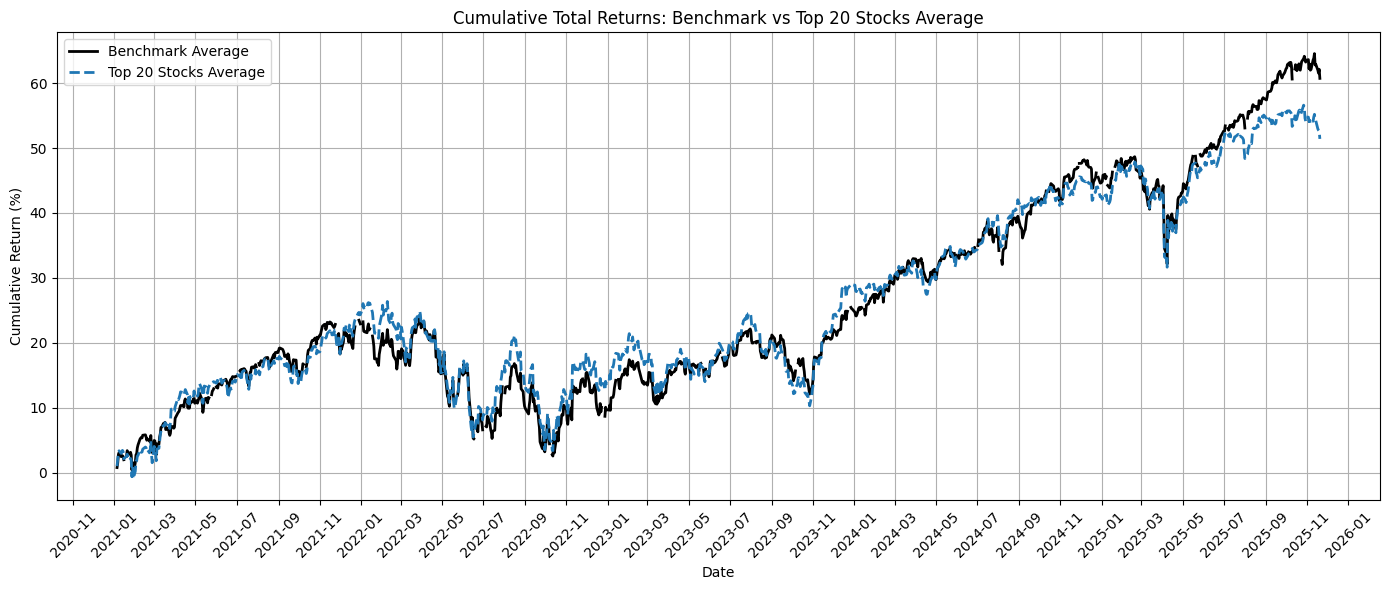

In [74]:
top_20_stocks = distances_df["Ticker"].head(20).tolist() # get the top 20 stocks closest to benchmark
top_20_returns = stock_total_returns[top_20_stocks] # get their returns

# get the average cumulative return of top 20 stocks
top_20_avg_return = top_20_returns.mean(axis=1)

# convert indices to datetime if not already
benchmark_df.index = pd.to_datetime(benchmark_df.index)
top_20_avg_return.index = pd.to_datetime(top_20_avg_return.index)

# plot cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(benchmark_df.index, benchmark_df["Benchmark Average"], label="Benchmark Average", color="black", linewidth=2) # plot benchmark cumulative returns
plt.plot(top_20_avg_return.index, top_20_avg_return, label="Top 20 Stocks Average", color="tab:blue", linestyle='--', linewidth=2) # plot top 20 average cumulative return

# format the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.title("Cumulative Total Returns: Benchmark vs Top 20 Stocks Average")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Portfolio Construction

The goal of this code is to construct a well-diversified portfolio of 20 stocks that contains both large-cap and small-cap companies while also ensuring that no single sector dominates the portfolio.

Note: Large-cap stocks are defined as having a market capitalization of at least 10 billion CAD, while small-cap stocks are defined as having a market capitalization below 2 billion CAD. All USD-denominated market capitalizations are converted to CAD.
<br>
<br>

* The code identifies all available large-cap and small-cap stocks using the pre-ranked `distances_df` dataframe, which orders stocks by how closely they track the benchmark average.

* Before selecting the remaining stocks, the algorithm forces the inclusion of one large-cap and one small-cap stock. Their sectors are recorded.

* We then iterate through the ranked list of stocks and add additional candidates while ensuring that no sector exceeds 40% of the portfolio.  
  * If adding a stock would cause a sector to exceed this, it is skipped.

* For every selected stock, the code retrieves its sector, converts the market capitalization into CAD, and classifies it as large-cap, mid-cap, or small-cap. This information is stored in a DataFrame, forming the basis of the final portfolio structure.
<br>
<br>

Before finalizing the portfolio, the code verifies that all constraints are satisfied:  
* There must be at least one large-cap and one small-cap stock,  
* No sector may exceed 40% of the portfolio size.

If any of these conditions are not met, the code raises an error or outputs a warning and does not finalize the portfolio.  
If all constraints are satisfied, the portfolio composition is displayed, including the count of large-cap and small-cap stocks and the distribution of sectors.



In [75]:
# get the live USD/CAD exchange rate
exchange_rate_ticker = yf.Ticker("CAD=X")
exchange_rate_data = exchange_rate_ticker.history(period="1d")
exchange_rate = exchange_rate_data['Close'].iloc[-1]

# categorize all available stocks by market cap
temp_large = []
temp_small = []

for ticker in distances_df['Ticker']: # for each ticker

    try: # check market cap in CAD and categorize
        stock = yf.Ticker(ticker)
        mc = stock.info.get('marketCap', 0)
        curr = stock.info.get('currency', 'USD')
         
        mc_cad = mc * exchange_rate if curr == 'USD' else mc
        
        if mc_cad > 10e9:
            temp_large.append(ticker)
        elif mc_cad < 2e9:
            temp_small.append(ticker)

    except: # in the event that anything goes wrong, we skip this ticker
        continue

# ensure we have at least 1 large and 1 small
if len(temp_large) == 0 or len(temp_small) == 0:
    raise Exception("Cannot meet requirements: found" + str(len(temp_large)) + " large-cap, " + str(len(temp_small)) + " small-cap (need at least 1 of each).")

# force 1 large and 1 small into selection
selected_tickers = [] # our final selected tickers
selected_tickers.append(temp_large[0])
selected_tickers.append(temp_small[0])

# get sectors for the 2 already selected
sector_counts_selected = {} # to count sectors
for ticker in selected_tickers: # for each selected ticker
    try: # to get sector
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        sector_counts_selected[sector] = sector_counts_selected.get(sector, 0) + 1 # add to count
    except: # in the event that anything goes wrong, we skip this ticker
        continue

# fill remaining slots with best trackers with respect to our 40% sector limit

target_n = 20 # target number of stocks
max_sector_frac = 0.4 # maximum sector fraction

for ticker in distances_df["Ticker"]: # for each ticker
    if ticker in selected_tickers: # skip if already selected
        continue
    if len(selected_tickers) >= target_n: # if we reached target number, we're done
        break
    
    if ticker not in temp_large and ticker not in temp_small: # if not large or small, skip
        continue
    
    try: # to get sector and check sector limit before adding
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        
        new_total = len(selected_tickers) + 1 # new total if we add this ticker
        new_sector_count = sector_counts_selected.get(sector, 0) + 1 # new sector count if we add this ticker
        new_sector_frac = new_sector_count / new_total # divide to get new sector fraction
        
        if new_sector_frac > max_sector_frac: # if above 40%, we skip
            continue
        
        # otheriwise we're good to go
        selected_tickers.append(ticker)
        sector_counts_selected[sector] = new_sector_count

    except: # in the event that anything goes wrong, we skip this ticker
        continue

print("Selected", len(selected_tickers), "stocks.")
print("Large-caps:", len([t for t in selected_tickers if t in temp_large]))
print("Small-caps:", len([t for t in selected_tickers if t in temp_small]))
print("Sector counts:" , sector_counts_selected) 

# will create a df with all the info we need on our final selected tickers
ticker_list = [] # will house tickers
sector_list = [] # will house sectors
market_cap_cad_list = [] # will house market caps in CAD
cap_type_list = [] # will house cap types

for ticker in selected_tickers: # for each selected ticker

    try: # to get info and categorize

        stock = yf.Ticker(ticker) # get ticker
        info = stock.info # get info dictionary
        
        # get the needed info
        sector = info.get('sector', 'Unknown')
        market_cap = info.get('marketCap', 0)
        currency = info.get('currency', 'USD')
        
        # convert market cap to CAD if needed
        if currency == 'USD':
            market_cap_cad = market_cap * exchange_rate
        else:
            market_cap_cad = market_cap
        
        # categorize by cap type
        if market_cap_cad > 10e9:
            cap_type = 'Large'
        elif market_cap_cad < 2e9:
            cap_type = 'Small'
        else:
            cap_type = 'Mid'
        
        # append to our lists
        ticker_list.append(ticker)
        sector_list.append(sector)
        market_cap_cad_list.append(market_cap_cad)
        cap_type_list.append(cap_type)
        
    except: # in the event that anything goes wrong, we skip this ticker
        continue

# create the df
stock_info = pd.DataFrame({
    'Ticker': ticker_list,
    'Sector': sector_list,
    'MarketCap_CAD': market_cap_cad_list,
    'CapType': cap_type_list
})

stock_info # display

Selected 20 stocks.
Large-caps: 19
Small-caps: 1
Sector counts: {'Technology': 3, 'Healthcare': 2, 'Industrials': 3, 'Consumer Defensive': 4, 'Financial Services': 6, 'Consumer Cyclical': 1, 'Communication Services': 1}


,Ticker,Sector,MarketCap_CAD,CapType
0,TXN,Technology,2.042047e+11,Large
1,AGN.CN,Healthcare,2.740497e+06,Small
2,UNP,Industrials,1.890826e+11,Large
3,KO,Consumer Defensive,4.423967e+11,Large
4,BLK,Financial Services,2.218444e+11,Large
5,PG,Consumer Defensive,4.977379e+11,Large
6,TD.TO,Financial Services,1.991012e+11,Large
7,ABT,Healthcare,3.141918e+11,Large
8,QCOM,Technology,2.482879e+11,Large
9,ACN,Technology,2.210422e+11,Large


## Relationships between the Stocks and the Benchmark

The purpose of the code below is to prepare the data for portfolio optimization by calculating the relationships between the selected stocks and the benchmark.

* Firstly, we extract the daily returns for our selected stocks and calculate benchmark daily returns as the average of the S&P and TSX. Then both datasets are aligned to the common dates

* Using the aligned stock returns, the code calculates a covariance matrix. This matrix is a 20×20 NumPy array where each element represents the covariance between a pair of stocks. This matrix shows how each stock moves relative to every other stock in the portfolio.

Note: While the code is designed to calculate a 20×20 covariance matrix for the selected portfolio of stocks, the actual size of the covariance matrix can vary depending on data availability. Some stocks may have missing return data for certain dates or may be removed during preprocessing steps such as dropping NaN values. As a result, the number of stocks included in the covariance matrix may be less than 20×20.


* For each stock, the covariance with the benchmark is calculated. These covariances indicate how closely each stock moves with the benchmark.

* Finally, the variance of the aligned benchmark returns is calculated. This measures the daily variability of the benchmark itself.



<div style="text-align: left;">

$$
\begin{align*}
\text{Let } & r_t^j \text{ be the daily return of stock } j \text{ on day } t, \quad j = 1, \dots, 20 \\ 
\text{Let } & r_t^{B} = \frac{r_t^{\text{SP}} + r_t^{\text{TSX}}}{2} \text{ be the benchmark daily return} \\[1mm]
\text{Aligned Returns:} \quad & \text{Consider only dates } t \in \mathcal{T}_{\text{common}} \text{ where both stock and benchmark returns exist} \\[1mm]
\text{Stock Covariance Matrix:} \quad & \Sigma = \Big[ \text{Cov}(r^i, r^j) \Big]_{i,j=1}^{20} \\[1mm]
\text{Covariance with Benchmark:} \quad & \text{cov}_{jB} = \text{Cov}(r^j, r^B), \quad j = 1, \dots, 20 \\[1mm]
\text{Benchmark Variance:} \quad & \sigma_B^2 = \text{Var}(r^B) \\[1mm]
\end{align*}
$$

</div>


<div style="text-align: left;">

The covariance matrix for the selected portfolio is represented symbolically as:

$$
\Sigma =
\begin{bmatrix}
\mathrm{Cov}(r^{1}, r^{1}) & \mathrm{Cov}(r^{1}, r^{2}) & \cdots & \mathrm{Cov}(r^{1}, r^{n}) \\
\mathrm{Cov}(r^{2}, r^{1}) & \mathrm{Cov}(r^{2}, r^{2}) & \cdots & \mathrm{Cov}(r^{2}, r^{n}) \\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{Cov}(r^{n}, r^{1}) & \mathrm{Cov}(r^{n}, r^{2}) & \cdots & \mathrm{Cov}(r^{n}, r^{n})
\end{bmatrix}
$$

Where:

$$
\mathrm{Cov}(r^{i}, r^{j}) = \frac{1}{T-1} \sum_{t=1}^{T} (r_t^{i} - \bar{r}^{i})(r_t^{j} - \bar{r}^{j})
$$

with:

- $r_t^{i}$ : Daily return of stock $i$ on day $t$  
- $r_t^{j}$ : Daily return of stock $j$ on day $t$  
- $\bar{r}^{i}$ : Mean return of stock $i$  
- $\bar{r}^{j}$ : Mean return of stock $j$  
- $T$ : Number of aligned trading days  
- $n$ : Number of stocks included after alignment (typically close to 20)

</div>

In [76]:
# get the daily returns for the selected stocks and drop NaNs
selected_stock_returns = stock_returns[selected_tickers].dropna()

# get the benchmark daily returns, going to be useful when using scipy optimization
benchmark_daily_returns = (sp_returns + tsx_returns) / 2

# have to use strftime otherwise we get a mismatch when comparing to the aligned stock returns index
benchmark_daily_returns.index = benchmark_daily_returns.index.strftime('%Y-%m-%d')

# find the common dates to use with .index intersection() for both the stock returns and benchmark returns (had to align them)
common_dates = selected_stock_returns.index.intersection(benchmark_daily_returns.index)
aligned_stock_returns = selected_stock_returns.loc[common_dates]
aligned_benchmark_returns = benchmark_daily_returns.loc[common_dates]

# use the covariance on aligned selected stock returns to generate matrix
cov_matrix = aligned_stock_returns.cov().values # with the data for now, matrix is 20x20 numpy array with covariances between all pairs of selected stocks

# calculate covariances between each stock and the benchmark
stock_benchmark_covariances = []

for ticker in selected_tickers: # for each of the selected tickers
    stock_returns_series = aligned_stock_returns[ticker] # assign series (1D array) to the common dates of the stock
    benchmark_returns_series = aligned_benchmark_returns # assign series (1D array) to the common dates of the benchmark returns
    covariance = stock_returns_series.cov(benchmark_returns_series) # calculate the covariance at that specific point (daily values)
    stock_benchmark_covariances.append(covariance) # add it to stock_benchmark relationship

# store as numpy array for scipy with all the covariances that we've appended to the empty list before the for loop (expects numpy array and also want consistensy with cov_matrix)
benchmark_cov = np.array(stock_benchmark_covariances)
    
# of the benchmark returns that are aligned with the common dates, how much does it go up and down daily 
benchmark_var = aligned_benchmark_returns.var()

# print to verify all three covariance components
print("Covariance matrix shape:", cov_matrix.shape) # how the stocks move relative to each other 
print("Benchmark covariances length:", len(benchmark_cov)) # how the stocks move with the benchmark
print("Benchmark variance:", benchmark_var) # how the benchmark moves

Covariance matrix shape: (20, 20)
Benchmark covariances length: 20
Benchmark variance: 8.030819060205976e-05


## Stock-Benchmark Covariances

This bar chart shows how each stock’s returns relate to the benchmark. Higher covariance bars indicate stocks that move with the benchmark, while lower covariance bars move against it. These covariances help guide portfolio weights to minimize tracking error while keeping diversification.

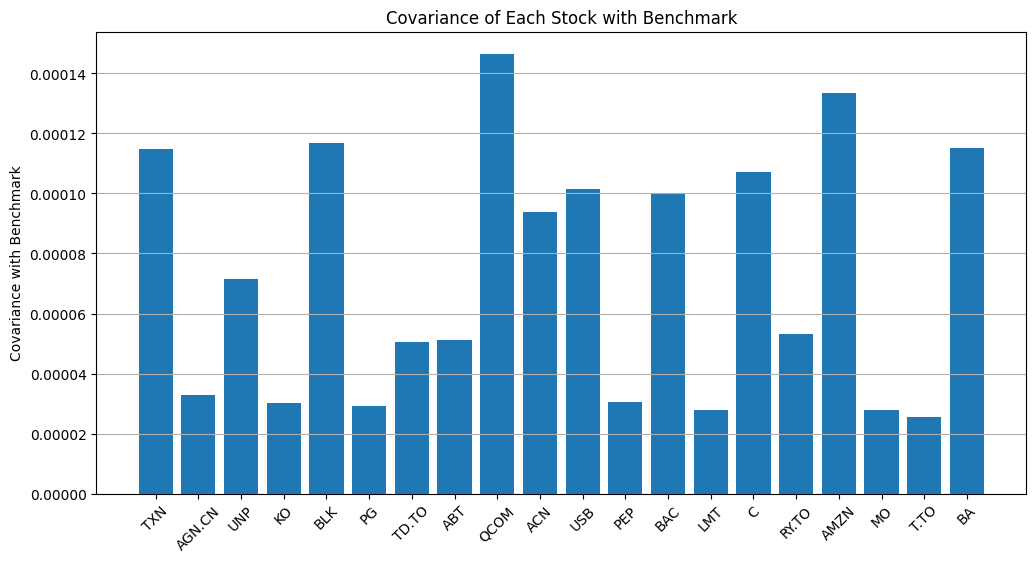

In [77]:
aligned_tickers = aligned_stock_returns.columns # get the tickers in the aligned stock returns using .columns

# plot the covariances to the benchmark
plt.figure(figsize=(12,6))
plt.bar(aligned_tickers, benchmark_cov)
plt.xticks(rotation=45)
plt.ylabel("Covariance with Benchmark")
plt.title("Covariance of Each Stock with Benchmark")
plt.grid(axis='y')
plt.show()

## Portfolio Optimization Using Error Variance Tracking

This code defines and solves a portfolio optimization problem that is based on the concept of tracking error variance. <br>
Tracking error quantifies how much a portfolio’s returns deviate from a benchmark.<br>
By minimizing tracking error, we can construct a portfolio that closely follows the performance of the benchmark.

<br>
<br>

$$
\text{Portfolio Variance:} \quad \sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w}
$$

where $\mathbf{w}$ is the vector of portfolio weights. This shows how the weighted combination of the selected stocks varies, taking into account both individual stock volatilities and correlations between the stocks. <br>
The inner dot product accounts for how stocks amplify each other’s returns, while the outer product applies the weights to compute the portfolio variance.  
<br>
<br>

$$
\text{Portfolio-Benchmark Covariance:} \quad \text{cov}_{pB} = \mathbf{w}^\top \text{cov}_B
$$

This term measures how the portfolio moves relative to the benchmark. It is a weighted sum of the covariances between each stock and the benchmark, reflecting how the composition of the portfolio affects its alignment with the benchmark.
<br>
<br>

$$
\text{Tracking Error Variance:} \quad \text{TEV} = \mathbf{w}^\top \Sigma \mathbf{w} - 2 \, \mathbf{w}^\top \text{cov}_B + \sigma_B^2
$$

This formula is derived from standard portfolio theory and expresses the variance of the difference between the portfolio return and the benchmark return. <br><br><br>
In addition, the code adds a beta penalty term so that the portfolio can have a beta close to 1 relative to the benchmark:

$$
\text{Beta Penalty:} \quad \text{Penalty} = 500 \cdot (\text{beta} - 1.0)^2, \quad \text{where } \text{beta} = \frac{\mathbf{w}^\top \text{cov}_B}{\sigma_B^2}
$$

This ensures that the portfolio not only minimizes tracking error but also tracks the benchmark directionally.
<br>

In addition to minimizing tracking error, the portfolio must satisfy several constraints:

* The weights must sum to 1 
* Each weight also has a minimum value, defined as $100/(2 \cdot n)$ percent of the portfolio
* Each weight has a maximum value of 15%
* Each sector cannot exceed 40% of the total portfolio weight
<br>

The optimizer requires an initial guess for the portfolio weights. <br>
In this code, the initial weights are distance-based rather than equal:  

* Stocks closer to the benchmark (smaller average distance) receive higher initial weights.  
* The raw scores are normalized to sum to 1.  
* Weights are then clipped to fall within the minimum and maximum bounds, and normalized again to sum to 1.  

This array serves as the starting point (`x0`) for the SLSQP optimizer.
<br>

Finally, the code checks `optimizer_data.success` to ensure the optimization converged. If not, an exception is raised.  

The resulting `optimal_weights` represent the portfolio allocation that:

* Minimizes tracking error relative to the benchmark  
* Maintains a beta close to 1  
* Respects minimum and maximum weights per stock  
* Ensures no sector exceeds 40%  



In [78]:
# define function that calculates tracking error variance
# input: weights (array of 20 numbers)
# calculate: portfolio_var = weights^T @ cov_matrix @ weights
# calculate: portfolio_bench_cov = weights^T @ benchmark_cov
# calculate: tracking_error_var = portfolio_var - 2*portfolio_bench_cov + benchmark_var
# return: tracking_error_var

def tracking_error_variance(weights):
    # inner dot product understands how the stocks amplify each other and outer dot product determines weights based on this interactions
    portfolio_var = np.dot(weights, np.dot(cov_matrix, weights))
    portfolio_bench_cov = np.dot(weights, benchmark_cov)
    # https://quant.stackexchange.com/questions/35720/ex-ante-tracking-error-active-strategies-and-the-size-of-the-covariance-matrix 
    # used this interesting source for calculating tracking error
    tracking_error_var = portfolio_var - 2 * portfolio_bench_cov + benchmark_var

    # calculate portfolio beta and add penalty to encourage beta closer to 1.0 (tracking error does its job but the restrictions made it have lower beta)
    portfolio_beta = portfolio_bench_cov / benchmark_var
    beta_penalty = 500 * (portfolio_beta - 1.0)**2

    return tracking_error_var + beta_penalty

# constraint 1: all weights must sum to 1 (100%)
# constraint 2: each weight must be >= minimum (100 / (2*n) percent)
# constraint 3: each weight must be <= 0.15 (15%)

num_stocks = len(selected_tickers) # get the number of stocks we selected
min_weight_stocks = (100/(2 * num_stocks)) / 100  # get the minimum weight per stock

# make dictionary to have each ticker with its sector
sector_lookup = {}
for i in range(len(stock_info)):
    t = stock_info.loc[i, "Ticker"]
    sector_lookup[t] = stock_info.loc[i, "Sector"]

# get each sector with the INDICES of its stocks in the weights list
sector_index_map = {}
for i in range(len(selected_tickers)):
    t = selected_tickers[i]
    sector = sector_lookup[t]
    if sector not in sector_index_map:
        sector_index_map[sector] = []
    sector_index_map[sector].append(i)

# this will verify with scipy that a function returns 0 when constraint is satisfied 
def weights_must_sum_to_one(weights):
    return np.sum(weights) - 1

constraints = [{'type': 'eq', 'fun': weights_must_sum_to_one}] # add the sum to one constraint

# do sector check per sector by summing to get the weight of each sector
for sector in sector_index_map:
    idx_list = sector_index_map[sector]

    def sector_constraint(weights, idx_list=idx_list):
        sector_weight = 0
        for j in idx_list:
            sector_weight = sector_weight + weights[j]
        return 0.40 - sector_weight # must be >= 0

    constraints.append({'type': 'ineq', 'fun': sector_constraint}) # add sector constraint

bounds = [] # create bounds list
for ticker in selected_tickers:
    # bounds requires (min, max) pairs for each element based on scipy documentation (pairs = tuples and we want them to be immutable)
    bounds.append((min_weight_stocks, 0.15))

# create initial_weights array; op[timizer needs a starting point before calculating based on the bounds which have been made
# x0 ndarray, shape (n,)
# initial guess: array of real elements of size (n,), where n is the number of independent variables
# required to pass in x0 as the starting guess for scipy

# get distances for the selected tickers in the same order
dist_for_port = distances_df[distances_df["Ticker"].isin(selected_tickers)]
dist_for_port = dist_for_port.set_index("Ticker")

distance_list = [] # get the list of distances
for t in selected_tickers:
    distance_list.append(dist_for_port.loc[t, "Average Distance"])

distance_array = np.array(distance_list) # convert to numpy array for calculations

# closer to benchmark (small distance) = bigger score
scores = 1.0 / distance_array

# turn scores into base weights that sum to 1
scores_sum = scores.sum()
raw_weights = scores / scores_sum

clipped_weights = np.clip(raw_weights, min_weight_stocks, 0.15) # force each weight to stay within set min and max values via .clip

initial_weights = clipped_weights / clipped_weights.sum() # ensure it sums to 1

# contains everything about how result went based on all the data fed into it
# using SLSQP method because it handles bounds and equality constraints efficiently
# extracts the optimal weights (x attribute) from the optimizer result object
optimizer_data = minimize(tracking_error_variance, initial_weights, method='SLSQP', bounds = bounds, constraints=constraints)

# check for optimization success
if not optimizer_data.success:
    print("Optimization failed: {optimizer_data.message}")
    raise Exception("Cannot find valid portfolio weights.")

# initially needed the x0 value, now calling the actual .x value from the optimizer 
optimal_weights = optimizer_data.x

# checks if optimization worked
print("Success:", optimizer_data.success)
print("Tracking error variance:", optimizer_data.fun)
print("Total weight:", np.sum(optimal_weights))
print()
print("Weights by stock: ")
print()
for i in range(len(selected_tickers)): # display weights by stock
    ticker = selected_tickers[i]
    print("" + ticker + ": " + str(np.round(optimal_weights[i] * 100, 2)) + "%")

Success: True
Tracking error variance: 1.852752704621737e-05
Total weight: 0.9999999999999999

Weights by stock: 

TXN: 8.3%
AGN.CN: 2.5%
UNP: 6.73%
KO: 6.33%
BLK: 8.67%
PG: 6.17%
TD.TO: 5.02%
ABT: 4.61%
QCOM: 7.06%
ACN: 4.5%
USB: 4.47%
PEP: 3.71%
BAC: 3.61%
LMT: 3.54%
C: 3.53%
RY.TO: 3.43%
AMZN: 5.91%
MO: 3.31%
T.TO: 3.08%
BA: 5.52%


## Portfolio Beta Calculation

This code calculates the beta of the optimized portfolio relative to the benchmark.

Beta measures the sensitivity of the portfolio's returns to movements in the benchmark, indicating how closely the portfolio tracks the benchmark.
A beta value close to 1 indicates that the portfolio moves in line with the benchmark, while values greater than 1 or less than 1 indicate higher or lower sensitivity, respectively.

In [79]:
# calculate portfolio beta relative to benchmark, measures how much portfolio moves relative to benchmark

# get portfolio returns using optimal weights (use ALIGNED returns)
portfolio_returns = (aligned_stock_returns * optimal_weights).sum(axis=1)

# calculate covariance between portfolio and benchmark (use ALIGNED benchmark)
portfolio_benchmark_cov = portfolio_returns.cov(aligned_benchmark_returns)

# calculate variance of benchmark (use ALIGNED benchmark)
benchmark_variance = aligned_benchmark_returns.var()

# beta = Cov(portfolio, benchmark) / Var(benchmark)
portfolio_beta = portfolio_benchmark_cov / benchmark_variance

print("Portfolio beta:", portfolio_beta)

Portfolio beta: 0.9999999856389719


## Post-Optimization Check

This block of code performs post-optimization checks to ensure that the final portfolio produced still complies with the constraints. While the optimization process focuses solely on minimizing tracking error, it may generate a set of weights that violate the requirements. Because of this, the code re-evaluates sector and market-cap constraints after optimization.

* The code first constructs a DataFrame (`portfolio_df`) that combines each selected stock with its optimized weight and descriptive information such as its sector and market-cap classification. Using this DataFrame, the code computes the total portfolio weight allocated to each sector by summing the weights per sector. The code prints the sector weights for transparency.

* To verify sector percentages, the code checks whether any sector exceeds the maximum allocation of 40%. A small tolerance (`0.0001`) is included to account for floating-point precision issues. If any sector exceeds 40% + tolerance, the code prints a sector weight violation message. If no sector violates the limit, it prints that there are no sector violations.

* Next, the code checks market-cap diversification. It calculates the total weight assigned to large-cap stocks and the total weight assigned to small-cap stocks. These totals are printed. The portfolio must include at least some weight in both large-cap and small-cap categories to satisfy the diversification requirement. If either total weight is zero, the code prints a market-cap violation message indicating that at least one stock from each category is required.


Communication Services: 3.08%
Consumer Cyclical: 5.91%
Consumer Defensive: 19.51%
Financial Services: 28.73%
Healthcare: 7.11%
Industrials: 15.79%
Technology: 19.86%

No sector weight violations.


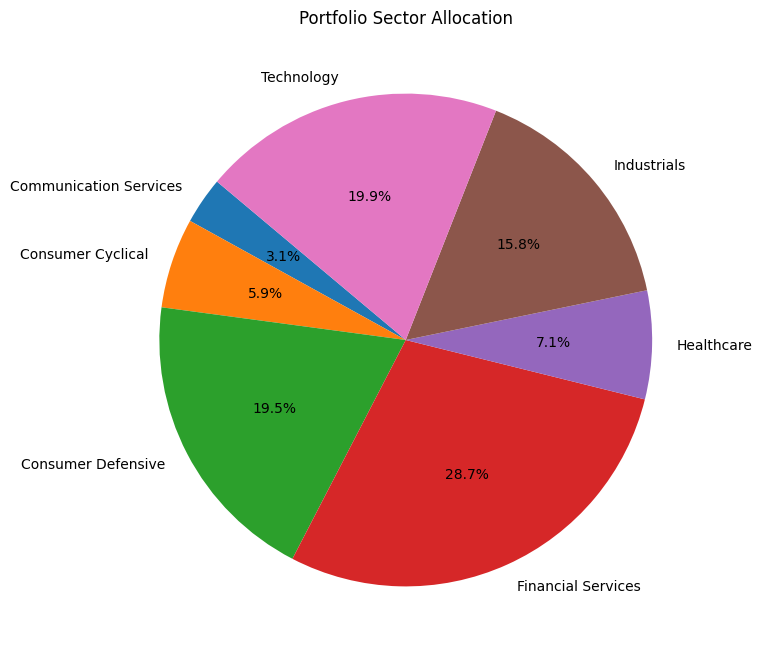

Total Large Cap Weight: 97.5%
Total Small Cap Weight: 2.5%

No market cap weight violations.


In [80]:
# now the initial 40% sector check was to see if the selected stocks were diverse enough
# after optimization, the new weights might violate those limits, so we redo the 40% sector check here
# even if those constraints make the weights slightly worse, we still have to follow the rules

# make a df for tickers and weights
dict = {"Ticker": selected_tickers, "Weight": optimal_weights}
weights_df = pd.DataFrame(dict)

# create portfolio df
portfolio_df = pd.merge(weights_df, stock_info , on="Ticker", how="inner")

# get sector weights
sector_weights_series = portfolio_df.groupby("Sector")["Weight"].sum()
sector_weights = sector_weights_series.to_dict()

# print them
for sector in sector_weights:
    print(str(sector) + ": " + str(np.round(sector_weights[sector] * 100, 2)) + "%")

print()

# check for sector violations (max 40% in one sector)
sector_violations = False
tolerance = 0.0001  # small tolerance to account for python's precision issues w/ numbers
for sector in sector_weights:
    if sector_weights[sector] > 0.4 + tolerance:
        sector_violations = True
        print("Sector weight violation: " + str(sector) + " is " + str(np.round(sector_weights[sector] * 100, 2)) + "%; max 40%.")

if not sector_violations:
    print("No sector weight violations.")

# create a little pie chart to display sector weights
plt.figure(figsize=(8,8))
plt.pie(sector_weights.values(), labels=sector_weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Sector Allocation")
plt.show()

# check for cap violations (need one large cap and one small cap minimum)
large_rows = portfolio_df[portfolio_df["CapType"] == "Large"]
large_weight_total = large_rows["Weight"].sum()

small_rows = portfolio_df[portfolio_df["CapType"] == "Small"]
small_weight_total = small_rows["Weight"].sum()

print("Total Large Cap Weight: " + str(np.round(large_weight_total * 100, 2)) + "%")
print("Total Small Cap Weight: " + str(np.round(small_weight_total * 100, 2)) + "%")
print()

if (not large_weight_total > 0) or (not small_weight_total > 0):
    print("Market cap weight violation; need at least one large cap and one small cap stock.")
else:
    print("No market cap weight violations.")

## Getting Prices for the Optimized Portfolio

This code block collects the most recent available closing price and the corresponding trading currency for each stock in the optimized portfolio.

It iterates through each row of the `portfolio_df`, fetching historical price data for the past five trading days but only storing the most recent closing price.  

If no price data is available for a ticker, it prints a message and skips that ticker.  

If the currency is not available, it defaults to “Unknown.”  


In [81]:
# create a dictionary with the ticker and its price and currency so we can convert for fees
price_data = {
    "Ticker": [],
    "Price": [],
    "Currency": []
}

for index, row in portfolio_df.iterrows(): # use .iterrows to go through each row of the portfolio df
    
    ticker = row["Ticker"] # get the ticker

    try: # to get price and currency
        
        stock = yf.Ticker(ticker)

        # get most recent available closing price (in this case when the code will fetch Nov 21st)
        hist = stock.history(period="5d")

        if hist.empty: # if empty, we skip
            print("No recent price data for " + ticker + ".")
            continue

        close_price = hist["Close"].iloc[-1] # get last available close price

        # extract currency
        currency = stock.info.get("currency", "Unknown")

        # add row to the df
        price_data["Ticker"].append(ticker)
        price_data["Price"].append(close_price)
        price_data["Currency"].append(currency)

    except Exception as e: # in the event that anything goes wrong, we skip this ticker
        print("Error fetching data for " + ticker + ": " + str(e))
        continue

# convert to df
prices_df = pd.DataFrame(price_data)

prices_df # display

,Ticker,Price,Currency
0,TXN,159.399994,USD
1,AGN.CN,0.080000,CAD
2,UNP,226.220001,USD
3,KO,72.949997,USD
4,BLK,1014.719971,USD
5,PG,150.919998,USD
6,TD.TO,115.589996,CAD
7,ABT,128.110001,USD
8,QCOM,163.300003,USD
9,ACN,251.850006,USD


## Transaction-Fee–Adjusted Portfolio Construction

This section of the code is responsible for converting the optimized portfolio weights into actual numbers of shares, converting currencies, transaction fees, and the final scaling of investment amounts. The process begins by merging the portfolio allocation with the price data collected earlier. This merged DataFrame includes each stock’s weight, price, and trading currency.

* Using the optimized weights, the code calculates each stock’s target dollar value before accounting for fees. Since some stocks may trade in USD, the target value is converted into the stock’s currency to ensure correct share calculations.

* Next, the code calculates the number of shares for each stock by dividing the target value by the stock’s market price. Transaction fees are:
  * flat USD 2.15 or 
  * 0.1% of the number of shares purchased—whichever is smaller. <br>

  These fees are always denominated in USD, so each fee is converted back to CAD using the exchange rate. The total CAD fees are then summed to determine how much of the initial one million dollars is consumed by transaction costs.

* Since fees reduce the amount that can actually be invested, the code calculates the investable amount remaining after fees and derives a scaling factor representing the proportion of the original budget that remains available. All initial target values are then scaled down using this factor so that the portfolio remains proportional while fitting within the reduced investable amount. After scaling, the code once again converts the adjusted values into the appropriate currency (USD or CAD), recalculates the number of shares, and computes each position’s final value.

Finally, it converts all positions back to CAD, calculates the final weight of each position relative to the total investable amount, and checks the consistency of the resulting portfolio. The process ensures that the final weights sum to 1 (or extremely close) and that the total invested amount matches the adjusted budget after fees.

In [82]:
# merge prices into portfolio
portfolio_with_prices = pd.merge(portfolio_df, prices_df, on="Ticker", how="inner")

# start with a budget of 1 million CAD
budget_cad = 1000000

# calculate initial target values based on optimal weights
portfolio_with_prices["TargetValue_CAD"] = portfolio_with_prices["Weight"] * budget_cad

# convert prices to CAD if necessary
target_values_stock_currency = []
for index, row in portfolio_with_prices.iterrows():
    if row["Currency"] == "USD":
        target_values_stock_currency.append(row["TargetValue_CAD"] / exchange_rate)
    else:
        target_values_stock_currency.append(row["TargetValue_CAD"])

portfolio_with_prices["TargetValue_StockCurrency"] = target_values_stock_currency # add to df

# calculate initial shares before fees
portfolio_with_prices["Shares"] = portfolio_with_prices["TargetValue_StockCurrency"] / portfolio_with_prices["Price"]

# calculate TOTAL fee for ENTIRE portfolio (not per stock)
total_shares = portfolio_with_prices["Shares"].sum()
total_fee_usd = min(2.15, 0.001 * total_shares)
total_fee_cad = total_fee_usd * exchange_rate

print("Transaction fees (CAD): $" + str(round(total_fee_cad, 2)))

# calculate investable amount after fees
investable_amount_cad = budget_cad - total_fee_cad
print("Investable amount after fees (CAD): $" + str(round(investable_amount_cad, 2)))

# scale all positions proportionally to fit investable amount
scaling_factor = investable_amount_cad / budget_cad

# apply scaling to get final shares
portfolio_with_prices["FinalShares"] = portfolio_with_prices["Shares"] * scaling_factor

# calculate final values in stock currency
portfolio_with_prices["FinalValue_StockCurrency"] = portfolio_with_prices["FinalShares"] * portfolio_with_prices["Price"]

# convert final values to CAD
final_values_cad = []
for index, row in portfolio_with_prices.iterrows():
    if row["Currency"] == "USD":
        final_values_cad.append(row["FinalValue_StockCurrency"] * exchange_rate)
    else:
        final_values_cad.append(row["FinalValue_StockCurrency"])

portfolio_with_prices["FinalValue_CAD"] = final_values_cad

# calculate final weights (basically weigfht of each stock in the final portfolio)
portfolio_with_prices["FinalWeight"] = portfolio_with_prices["FinalValue_CAD"] / investable_amount_cad

# verify totals
total_portfolio_value = portfolio_with_prices["FinalValue_CAD"].sum()
total_weights = portfolio_with_prices["FinalWeight"].sum()

print()
print("Total portfolio value (CAD): $" + str(round(total_portfolio_value, 2)))
print("Difference from investable amount (CAD): $" + str(round(investable_amount_cad - total_portfolio_value, 2)))
print()
print("Total weights sum to: " + str(total_weights))

portfolio_with_prices # display modified portfolio with everything

Transaction fees (CAD): $3.03
Investable amount after fees (CAD): $999996.97

Total portfolio value (CAD): $999996.97
Difference from investable amount (CAD): $0.0

Total weights sum to: 0.9999999999999999


,Ticker,Weight,Sector,MarketCap_CAD,CapType,Price,Currency,TargetValue_CAD,TargetValue_StockCurrency,Shares,FinalShares,FinalValue_StockCurrency,FinalValue_CAD,FinalWeight
0,TXN,0.083009,Technology,2.042047e+11,Large,159.399994,USD,83008.543303,58908.074149,369.561333,369.560213,58907.895681,83008.291820,0.083009
1,AGN.CN,0.025000,Healthcare,2.740497e+06,Small,0.080000,CAD,25000.000000,25000.000000,312500.006985,312499.060232,24999.924260,24999.924260,0.025000
2,UNP,0.067292,Industrials,1.890826e+11,Large,226.220001,USD,67292.276930,47754.824760,211.099039,211.098399,47754.680082,67292.073060,0.067292
3,KO,0.063284,Consumer Defensive,4.423967e+11,Large,72.949997,USD,63283.571238,44909.995508,615.627106,615.625241,44909.859448,63283.379513,0.063284
4,BLK,0.086700,Financial Services,2.218444e+11,Large,1014.719971,USD,86700.397603,61528.045759,60.635493,60.635309,61527.859353,86700.134935,0.086700
5,PG,0.061679,Consumer Defensive,4.977379e+11,Large,150.919998,USD,61678.588038,43770.998659,290.027824,290.026945,43770.866050,61678.401176,0.061679
6,TD.TO,0.050217,Financial Services,1.991012e+11,Large,115.589996,CAD,50217.404184,50217.404184,434.444206,434.442890,50217.252045,50217.252045,0.050217
7,ABT,0.046123,Healthcare,3.141918e+11,Large,128.110001,USD,46123.326704,32732.008554,255.499246,255.498472,32731.909389,46123.186969,0.046123
8,QCOM,0.070582,Technology,2.482879e+11,Large,163.300003,USD,70581.979069,50089.403947,306.732413,306.731484,50089.252196,70581.765233,0.070582
9,ACN,0.044996,Technology,2.210422e+11,Large,251.850006,USD,44995.936875,31931.941947,126.789522,126.789138,31931.845206,44995.800555,0.044996


## Final Portfolio Formatting

This prepares the final portfolio dataset for presentation and export after all fee and currency adjustments are completed.

In [83]:
# create portfolio with the required columns
final_portfolio = portfolio_with_prices[["Ticker", "Price", "Currency", "FinalShares", "FinalValue_CAD", "FinalWeight"]].copy()

# rename the columns to fit requirements
final_portfolio = final_portfolio.rename(columns={
    "FinalShares": "Shares",
    "FinalValue_CAD": "Value",
    "FinalWeight": "Weight"
})

# convert the weights to a percentage
final_portfolio["Weight"] = final_portfolio["Weight"] * 100

# reset index to start at 1
final_portfolio.index = range(1, len(final_portfolio) + 1)

# print relevant data about value and weights
total_value = final_portfolio["Value"].sum()
total_weight = final_portfolio["Weight"].sum()

print("Total portfolio value (CAD): " + str(round(total_value, 2)))
print("Total portfolio weight (%): " + str(round(total_weight, 2)))

# make a df with the ticker and shares purchased 
shares_purchased_df = final_portfolio[["Ticker", "Shares"]].copy()

# export to csv
shares_purchased_df.to_csv("Stocks_Group_06.csv", index=False)

print()
print("Portfolio contains " + (str(len(final_portfolio))) + " stocks.")
print("Shares purchased exported to Stocks_Group_06.csv")

final_portfolio # display final portfolio

Total portfolio value (CAD): 999996.97
Total portfolio weight (%): 100.0

Portfolio contains 20 stocks.
Shares purchased exported to Stocks_Group_06.csv


,Ticker,Price,Currency,Shares,Value,Weight
1,TXN,159.399994,USD,369.560213,83008.291820,8.300854
2,AGN.CN,0.080000,CAD,312499.060232,24999.924260,2.500000
3,UNP,226.220001,USD,211.098399,67292.073060,6.729228
4,KO,72.949997,USD,615.625241,63283.379513,6.328357
5,BLK,1014.719971,USD,60.635309,86700.134935,8.670040
6,PG,150.919998,USD,290.026945,61678.401176,6.167859
7,TD.TO,115.589996,CAD,434.442890,50217.252045,5.021740
8,ABT,128.110001,USD,255.498472,46123.186969,4.612333
9,QCOM,163.300003,USD,306.731484,70581.765233,7.058198
10,ACN,251.850006,USD,126.789138,44995.800555,4.499594


## YAP SUM MORE

/var/folders/hk/4jtzk4tx5kgbr895rh0gtm8r0000gn/T/ipykernel_60815/176670527.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  portfolio_daily_returns = portfolio_close.pct_change().dropna()


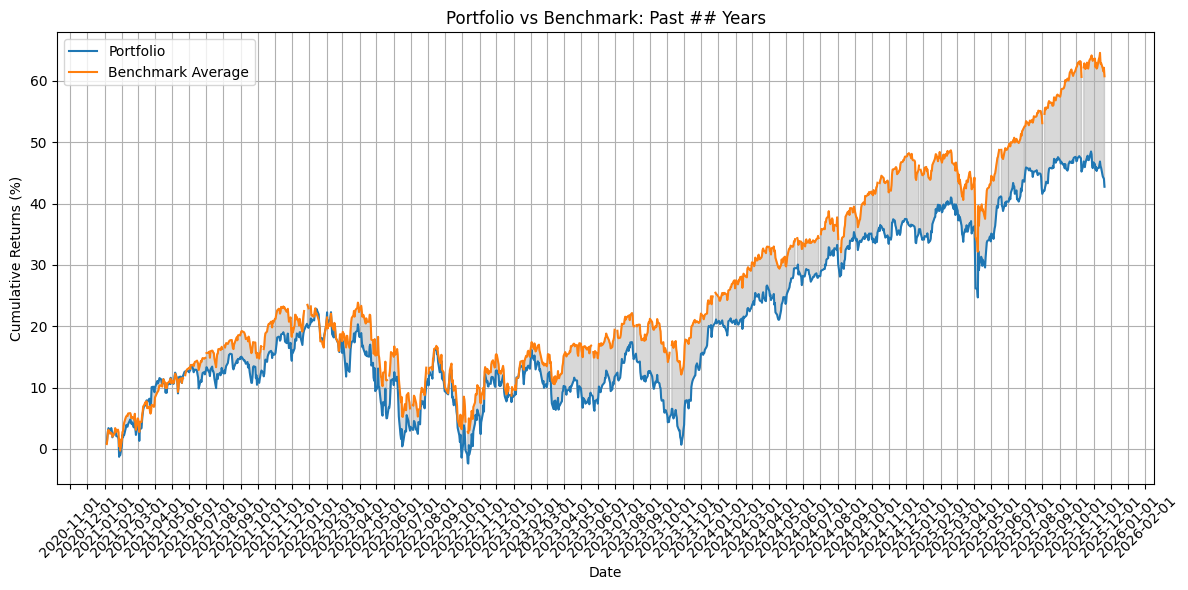

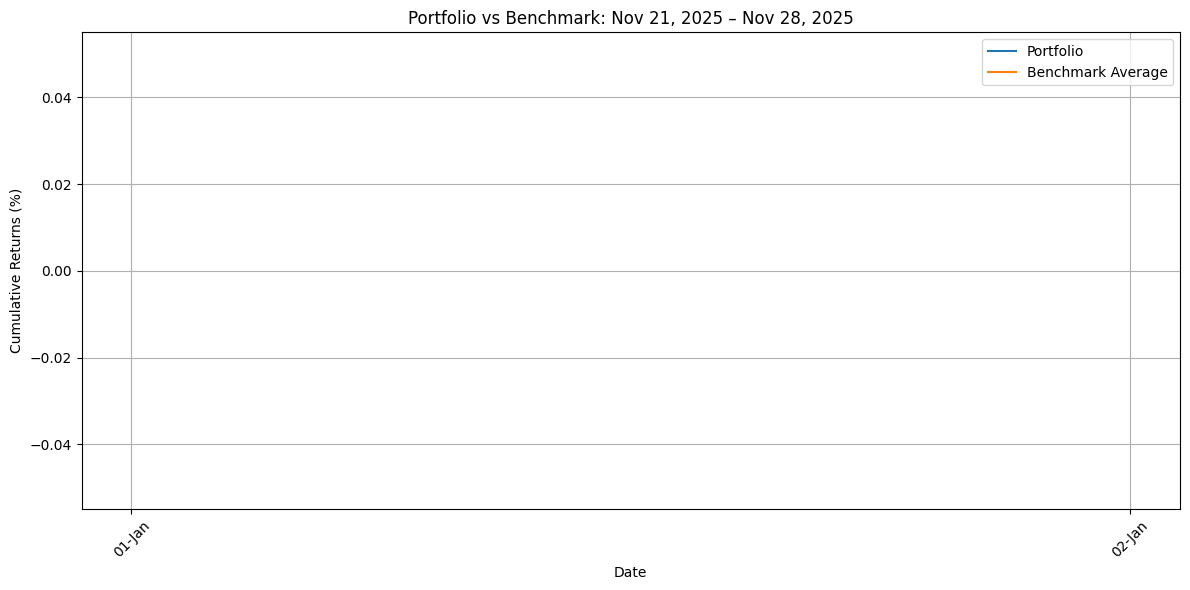

In [84]:
# get daily returns for final portfolio tickers
portfolio_tickers = final_portfolio["Ticker"].tolist()
portfolio_weights = final_portfolio["Weight"].values / 100 

# filter close_prices for the portfolio tickers
portfolio_close = close_prices[portfolio_tickers]

# calculate daily returns
portfolio_daily_returns = portfolio_close.pct_change().dropna()

# weighted portfolio returns
weighted_returns = (portfolio_daily_returns * portfolio_weights).sum(axis=1)

# cumulative returns
portfolio_cum_returns = (weighted_returns.cumsum()) * 100

# benchmark cumulative returns (average of S&P500 and TSX)
benchmark_cum_returns = (sp_total_return + tsx_total_return) / 2
benchmark_cum_returns.index = benchmark_cum_returns.index.strftime('%Y-%m-%d')

# reset index to get a date column and give series a name
portfolio_df = portfolio_cum_returns.reset_index().rename(columns={0: "Portfolio", "index": "Date"})
benchmark_df = benchmark_cum_returns.rename("Benchmark").reset_index().rename(columns={"index": "Date"})

# nerge on date
plot_df = pd.merge(portfolio_df, benchmark_df, on="Date", how="inner")

plot_df["Date"] = pd.to_datetime(plot_df["Date"])
plot_df

# plot 1-year cumulative returns 
plt.figure(figsize=(12,6))
plt.plot(plot_df["Date"], plot_df["Portfolio"], label="Portfolio")
plt.plot(plot_df["Date"], plot_df["Benchmark"], label="Benchmark Average")
plt.fill_between(plot_df["Date"], plot_df["Portfolio"], plot_df["Benchmark"], color="gray", alpha=0.3)
plt.title("Portfolio vs Benchmark: Past ## Years")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # one tick per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# slice dates for the next week
next_week_mask = (plot_df["Date"] >= "2025-11-21") & (plot_df["Date"] <= "2025-11-28")
next_week_df = plot_df.loc[next_week_mask]

plt.figure(figsize=(12,6))
plt.plot(next_week_df["Date"], next_week_df["Portfolio"], label="Portfolio")
plt.plot(next_week_df["Date"], next_week_df["Benchmark"], label="Benchmark Average")
plt.title("Portfolio vs Benchmark: Nov 21, 2025 – Nov 28, 2025")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)

# format x-axis: daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Shayan Jalali, Krish Suryavanshi, Paul Reddy